Salient Object Detection — Demo Notebook

1. Import required libraries

In [7]:
import os
import time

import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from sod_model import SODNet


2. Load trained SOD model


In [2]:
# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create model (same config as training)
model = SODNet(in_channels=3, base_channels=32).to(device)

# Load best checkpoint
ckpt_path = os.path.join("checkpoints", "best_model.pth")
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint not found at {ckpt_path}")

state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Loaded weights from:", ckpt_path)


Using device: cuda
Loaded weights from: checkpoints\best_model.pth


C:\Users\Berdyna Tech\AppData\Local\Temp\ipykernel_12984\84395294.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=device

3. Helper functions for preprocessing, inference, and visualization

In [3]:
def load_and_preprocess_image(image_path: str, img_size: int = 128):
    """
    Loads an RGB image, resizes to 128x128, converts to tensor [1, 3, H, W] on device.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(image_path)

    img_pil = Image.open(image_path).convert("RGB")
    img_pil = img_pil.resize((img_size, img_size))

    img_tensor = TF.to_tensor(img_pil).unsqueeze(0)  # [1, 3, H, W]
    img_tensor = img_tensor.to(device)

    return img_pil, img_tensor


def predict_saliency(image_tensor: torch.Tensor):
    """
    Runs the model and returns:
    - prediction mask as 2D tensor [H, W]
    - inference time in milliseconds
    """
    with torch.no_grad():
        start = time.time()
        pred = model(image_tensor)  # [1, 1, H, W]
        end = time.time()

    # Remove batch & channel dims -> [H, W]
    pred_mask = pred.squeeze(0).squeeze(0).cpu()

    inference_ms = (end - start) * 1000.0
    return pred_mask, inference_ms


def show_result(img_pil, pred_mask, title_extra=""):
    """
    Shows:
    - Input image
    - Predicted mask
    - Overlay (mask on top of image)
    """
    img_np = img_pil  # PIL image
    pred_np = pred_mask.numpy()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img_np)
    axes[0].set_title("Input")
    axes[0].axis("off")

    axes[1].imshow(pred_np, cmap="gray")
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")

    axes[2].imshow(img_np)
    axes[2].imshow(pred_np, cmap="jet", alpha=0.4)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    if title_extra:
        fig.suptitle(title_extra)

    plt.tight_layout()
    plt.show()


4. Run saliency prediction on a sample image

Inference time: 5.54 ms for ILSVRC2012_test_00000004.jpg


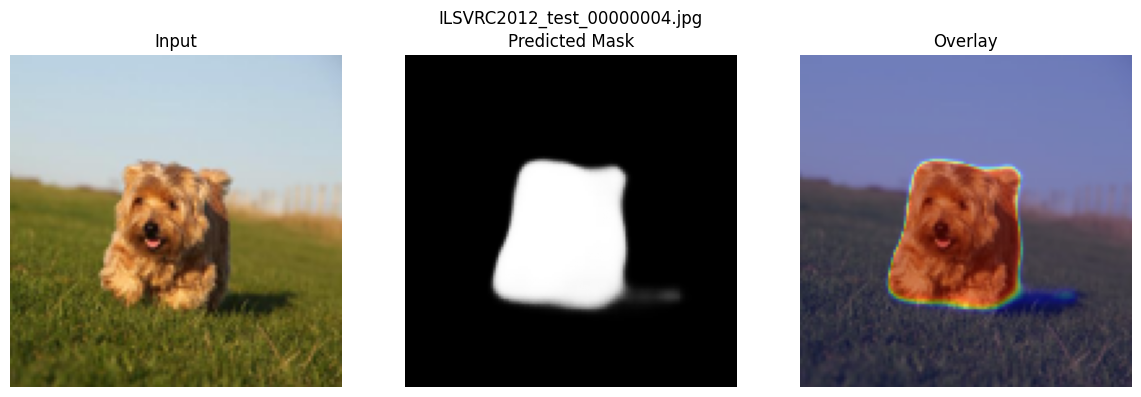

In [8]:
# Pick an image from DUTS (change this name if you want)
image_name = "ILSVRC2012_test_00000004.jpg"
image_path = os.path.join("data", "DUTS", "images", image_name)

img_pil, img_tensor = load_and_preprocess_image(image_path)

pred_mask, inf_ms = predict_saliency(img_tensor)

print(f"Inference time: {inf_ms:.2f} ms for {image_name}")

show_result(img_pil, pred_mask, title_extra=image_name)


5. Run the model on multiple random images


Example 1 - n04131690_1371.jpg | Inference: 4.76 ms


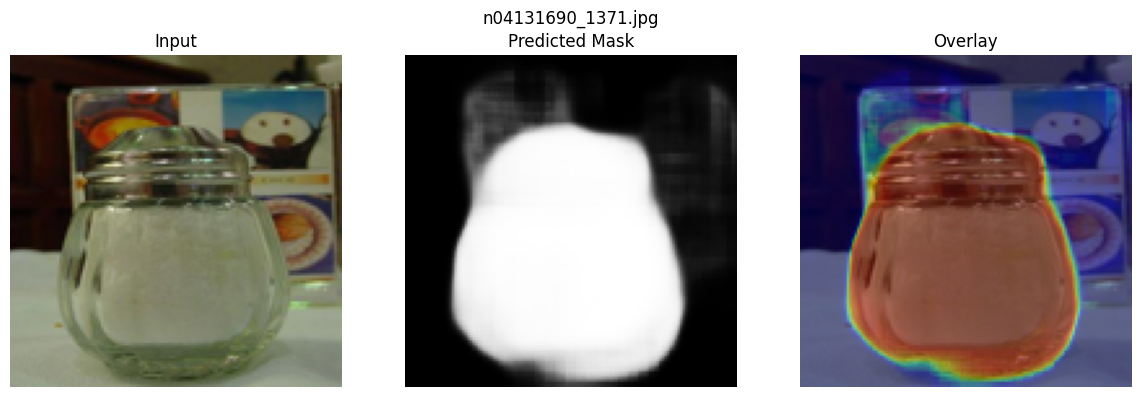


Example 2 - ILSVRC2012_test_00037310.jpg | Inference: 3.81 ms


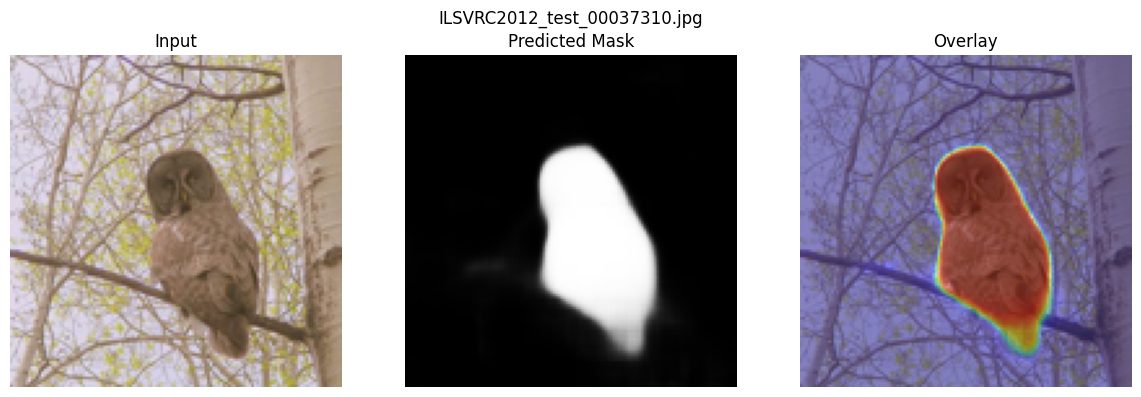


Example 3 - ILSVRC2012_test_00026663.jpg | Inference: 4.11 ms


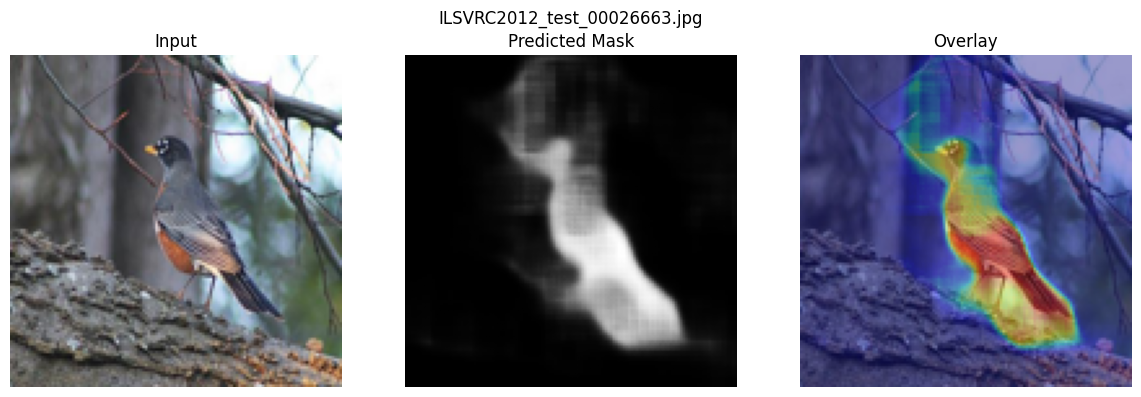

In [6]:
import random

images_dir = os.path.join("data", "DUTS", "images")
all_images = [f for f in os.listdir(images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

for i in range(3):  # show 3 random examples
    image_name = random.choice(all_images)
    image_path = os.path.join(images_dir, image_name)

    img_pil, img_tensor = load_and_preprocess_image(image_path)
    pred_mask, inf_ms = predict_saliency(img_tensor)

    print(f"\nExample {i+1} - {image_name} | Inference: {inf_ms:.2f} ms")
    show_result(img_pil, pred_mask, title_extra=image_name)
